In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import sympy as sym
import numpy as np
import scipy as sp

from sympy import sin, cos

sns.set()
plt.rcParams["figure.figsize"] = (8,8)

# Part A

First find the FIM:
$$F_\theta = \frac{\partial \mu(\theta)}{\partial \theta}^T Q^{-1} \frac{\partial \mu(\theta)}{\partial \theta}$$

<br>

$$\frac{\partial \mu(\theta)}{\partial \theta} = \begin{bmatrix} 
    \frac{\partial}{\partial \theta} \big (1 - cos(\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(2\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(3\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(4\theta) \big ) \\
\end{bmatrix} = \begin{bmatrix} 
    sin(\theta) \\
    2 sin(2\theta) \\
    3 sin(3\theta) \\
    4 sin(4\theta) \\
\end{bmatrix}$$

<br>

\begin{align*}
F_\theta &= \frac{1}{\sigma^2}\big (sin(\theta) \big )^2 + \frac{1}{\sigma^2}\big (2 sin(2\theta) \big )^2 + \frac{1}{\sigma^2}\big (3 sin(3\theta) \big )^2 + \frac{1}{\sigma^2}\big (4 sin(4\theta) \big )^2 \\
         &= \frac{1}{\sigma^2} \Big (sin^2(\theta) + 4 sin^2(2\theta) + 9 sin^2(3\theta) + 16 sin^2(4\theta) \Big ) \\
         &= \frac{1}{\sigma^2} \sum\limits_{i=1}^{4} i^2 sin(i \theta)
\end{align*}


In [2]:
sigma_2 = 1  # Sigma squared
thetas = np.linspace(0, np.pi, 1000)  # Theta range from 0 to pi

def fisher(sigma_2, theta):
    return (1 / sigma_2) * ((np.sin(theta))**2 + (2 * np.sin(2 * theta))**2 + (3 * np.sin(3 * theta))**2 + (4 * np.sin(4 * theta))**2)


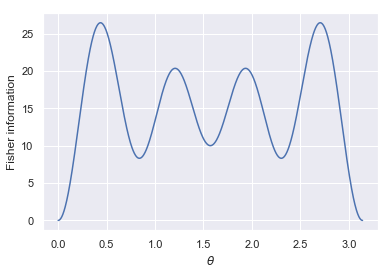

In [3]:
plt.plot(thetas, fisher(sigma_2, thetas))
plt.xlabel("$\\theta$")
plt.ylabel("Fisher information")
plt.show()

# Part B

In [4]:
def sample_x(theta, n=1, sigma_2=0.1):
    """Same as np.random.multivariate_normal but 2x faster for diagonal covariances"""
    return np.array([
        np.random.normal(1 - np.cos(theta), sigma_2, size=n),
        np.random.normal(1 - np.cos(2*theta), sigma_2, size=n),
        np.random.normal(1 - np.cos(3*theta), sigma_2, size=n),
        np.random.normal(1 - np.cos(4*theta), sigma_2, size=n),
    ])

xs = np.mean(sample_x(0.5), axis=1)
# Test to make sure they're all be close to 0.5
np.arccos(1-xs[0]), np.arccos(1-xs[1])/2, np.arccos(1-xs[2])/3, np.arccos(1-xs[3])/4

(0.6918035495614392,
 0.48162410769050007,
 0.4975565067289343,
 0.5043582849853018)

In [5]:
# For use in scipy.optimize.least_squares (the cost functon for the estimator)
def fun_microphone_array(theta, samples):
    correct = np.array([
        1 - np.cos(theta),
        1 - np.cos(2*theta),
        1 - np.cos(3*theta),
        1 - np.cos(4*theta)
    ])
    cost = np.sum((samples - correct)**2)
    return cost

In [6]:
def estimate_theta_info(theta, theta_hat_0=0.5, n_samples=1, sigma_2=0.1, n_mc=100):
    """Estimate the mean, variance, and bias of the estimator of n_samples samples, and n_mc runs.
    
    Note: I think the question uses n_samples = 1 from the equations given but it's not so clear.
    Using a higher n_samples will obviously improve the estimate from least squares...

    Arguments:
        theta       : Real theta that generates the data
        theta_hat_0 : Initial estimate for theta for the least squares function (it needs a starting point)
        n_samples   : Number of samples generated
        sigma_2     : Sigma^2 of the generation
        n_mc        : Number of monte carlo iterations (how many times to run least squares to)\

    Return tuple of:
        mu         : Mean of the estimator
        sigma      : Variance of the estimator
        bias       : Bias of the estimator
        mse        : Mean square error of the estimator
        sq_errs    : (Extra) square error for each monte-carlo run
        theta_hats : (Extra) the estimate for each monte-carlo run
        
        *Extra - since the run takes a significant amount of time also return the values for each
                 individual run to do additional possible calculations
    """
    x0 = theta_hat_0
    theta_hats = np.zeros(n_mc)
    sq_errs = np.zeros(n_mc)
    
    for i in range(n_mc):
        xs = sample_x(theta, n=n_samples, sigma_2=sigma_2)
        
        ## Faster but does not allow for bounds
        # estimate = sp.optimize.least_squares(fun_microphone_array, x0, method='lm', kwargs={'samples': xs})
        # `trf` is ~6x slower than `lm` but allows for bounds on the solution
        estimate = sp.optimize.least_squares(fun_microphone_array, x0, method='trf', bounds=(0,1), kwargs={'samples': xs})
        
        theta_hats[i] = estimate['x']  # Get the actual theta_hat from the least_squares function
        sq_errs[i] = estimate['cost']
    
    # Calculate mu, sigma, & bias from MC run
    mu = np.mean(theta_hats)
    sigma = np.var(theta_hats)
    bias = np.mean(theta_hats - theta)  # Bias as given in part B
    mse = np.mean(sq_errs)
    
    return mu, sigma, bias, mse, sq_errs, theta_hats


In [7]:
import time
t = time.time()

# Run Monte-Carlo with theta range [0,1]
n_thetas = 1001
thetas = np.linspace(0, 1, n_thetas)

# Select run values
theta_hat_0 = 0.5  # intitial theta estimate for scipy least squares function
n_samples = 1
sigma_2 = 0.1
n_mc = 500  # Number of monte-carlo iterations (higher n means more accurate means, vars, & biases)
print_time = 100  # Print every x seconds

# Initialize a arrays for the mean, variance, and bias
mus = np.zeros_like(thetas)
sigmas = np.zeros_like(thetas)
biases = np.zeros_like(thetas)
mses = np.zeros_like(thetas)
theta_hats = np.zeros(thetas.shape + (n_mc,))
sq_errs = np.zeros(thetas.shape + (n_mc,))

prev_t = t
for i, theta in enumerate(thetas):
    # Print progress every x seconds
    if time.time() - prev_t > print_time:
        prev_t = time.time()
        print(f'Theta {i} out of {n_thetas}, time established={time.time() - t:.0f} seconds')

    mus[i], sigmas[i], biases[i], mses[i], sq_errs[i], theta_hats[i] = estimate_theta_info(theta, theta_hat_0, n_samples, sigma_2, n_mc)
    
print(f'Total time={time.time() - t:.1f} seconds')  # Time the run to estimate length of more accurate experiments

Theta 34 out of 1001, time established=100 seconds
Theta 66 out of 1001, time established=201 seconds
Theta 98 out of 1001, time established=303 seconds
Theta 127 out of 1001, time established=404 seconds
Theta 154 out of 1001, time established=506 seconds
Theta 182 out of 1001, time established=609 seconds
Theta 211 out of 1001, time established=710 seconds
Theta 241 out of 1001, time established=813 seconds
Theta 272 out of 1001, time established=914 seconds
Theta 302 out of 1001, time established=1016 seconds
Theta 332 out of 1001, time established=1116 seconds
Theta 363 out of 1001, time established=1216 seconds
Theta 395 out of 1001, time established=1316 seconds
Theta 428 out of 1001, time established=1416 seconds
Theta 463 out of 1001, time established=1518 seconds
Theta 501 out of 1001, time established=1619 seconds
Theta 538 out of 1001, time established=1720 seconds
Theta 571 out of 1001, time established=1822 seconds
Theta 605 out of 1001, time established=1923 seconds
Theta

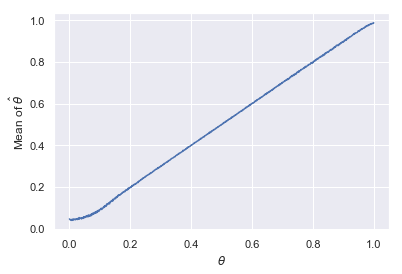

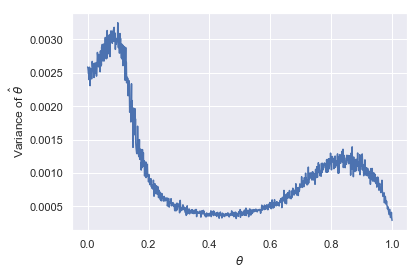

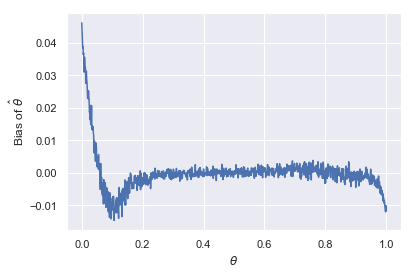

In [8]:
ys = [mus, sigmas, biases]
ylabels = ['Mean of $\hat \\theta$', 'Variance of $\hat \\theta$', 'Bias of $\hat \\theta$']

for y, ylabel in zip(ys, ylabels):
    plt.plot(thetas, y)
    plt.xlabel('$\\theta$')
    plt.ylabel(ylabel)
    plt.show()


# Part C

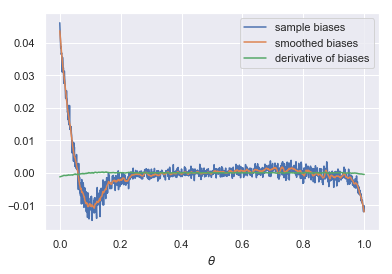

In [9]:
# Plot a smoothing of biases to see what is approx a good window len and polynomial order for the filter (used in the derivative calc)
smoothed_biases = sp.signal.savgol_filter(biases, window_length=21, polyorder=2, deriv=0)
d_biases = sp.signal.savgol_filter(biases, window_length=21, polyorder=2, deriv=1)

plt.plot(thetas, biases, label='sample biases')
plt.plot(thetas, smoothed_biases, label='smoothed biases')
plt.plot(thetas, d_biases, label='derivative of biases')
plt.xlabel('$\\theta$')
plt.legend()
plt.show()

In [10]:
j_thetas = fisher(0.1, thetas)
j_thetas[0] = j_thetas[1]  # Remove a divide by zero

# Calulcate the derivative of biases
d_biases = sp.signal.savgol_filter(biases, window_length=21, polyorder=2, deriv=1)

crlb = j_thetas**(-1)
mcrlb = ((d_biases + 1)**2 / j_thetas) + biases**2

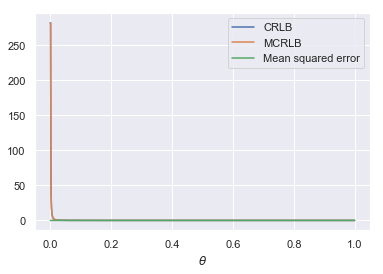

In [12]:
ys = [crlb, mcrlb, mses]
ylabels = ['CRLB', 'MCRLB', 'Mean squared error']

for y, ylabel in zip(ys, ylabels):
    plt.plot(thetas, y, label=ylabel)

plt.ylim((0, .02))
plt.xlabel('$\\theta$')
plt.legend()
plt.show()